# Python -- Decision Tree


## Step 1: Import important packages, set the standard plot format, and set the path of saving images 

In [101]:
#Code borrowed from class note
from __future__ import division, print_function, unicode_literals
import numpy as np
import scipy as sp
import os
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)


def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Step 2: Load data, explore data and data cleaning

I used several methods to explore data. The data set has 31891 rows and 12 columns, and there's no null value in the dataset.

In [102]:
data = pd.read_csv("data/HW1_Data.csv")
print(data.head())
print(data.shape)
print(data.info())
print(data.describe())

   revenue  outcalls  incalls  months  eqpdays  webcap  marryyes  travel  \
0    83.53     20.00      1.0      31      745       1         0       0   
1    29.99      0.00      0.0      52     1441       0         0       0   
2    37.75      2.67      0.0      25      572       0         0       0   
3     5.25      0.00      0.0      45     1354       0         0       0   
4    42.71      8.67      0.0      27      224       1         0       0   

   pcown  creditcd  retcalls  churndep  
0      0         0         4         1  
1      1         1         3         1  
2      1         1         3         1  
3      0         0         2         1  
4      0         0         3         1  
(31891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31891 entries, 0 to 31890
Data columns (total 12 columns):
revenue     31891 non-null float64
outcalls    31891 non-null float64
incalls     31891 non-null float64
months      31891 non-null int64
eqpdays     31891 non-null int64
webca

I found that 'eqpdays' and 'revenue' had values below 0, according to the description of these variables, I thought it's abnormal, and I counted the numbers of abnormal observations to see if the number is small. (If it's small, then I can exclude them.)
And I found that 'webcap' is also a binominal variable (which is not mentioned in HW1 file), and 'retcalls' is a polynominal variable.

In [103]:
print(data[data['eqpdays'] < 0].count())
print(data[data['revenue'] < 0].count())
print(data['webcap'].nunique())
print(data['retcalls'].value_counts())

revenue     46
outcalls    46
incalls     46
months      46
eqpdays     46
webcap      46
marryyes    46
travel      46
pcown       46
creditcd    46
retcalls    46
churndep    46
dtype: int64
revenue     1
outcalls    1
incalls     1
months      1
eqpdays     1
webcap      1
marryyes    1
travel      1
pcown       1
creditcd    1
retcalls    1
churndep    1
dtype: int64
2
0    30602
1     1186
2       90
3       12
4        1
Name: retcalls, dtype: int64


Since the number of abnormal observations is small, so I just excluded them. And I transferred 'webcap', 'marryyes', 'travel', 'pcown', 'creditcd' and 'churndep' into categorical variables.

In [104]:
dat = data[(data['eqpdays'] >= 0) & (data['revenue'] >= 0)]
dat.loc[:,"webcap"] = dat.loc[:,"webcap"].astype('category')
dat.loc[:,"marryyes"] = dat.loc[:,"marryyes"].astype('category')
dat.loc[:,"travel"] = dat.loc[:,"travel"].astype('category')
dat.loc[:,"pcown"] = dat.loc[:,"pcown"].astype('category')
dat.loc[:,"creditcd"] = dat.loc[:,"creditcd"].astype('category')
dat.loc[:,"churndep"] = dat.loc[:,"churndep"].astype('category')
print(dat.info())
print(dat.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31844 entries, 0 to 31890
Data columns (total 12 columns):
revenue     31844 non-null float64
outcalls    31844 non-null float64
incalls     31844 non-null float64
months      31844 non-null int64
eqpdays     31844 non-null int64
webcap      31844 non-null category
marryyes    31844 non-null category
travel      31844 non-null category
pcown       31844 non-null category
creditcd    31844 non-null category
retcalls    31844 non-null int64
churndep    31844 non-null category
dtypes: category(6), float64(3), int64(3)
memory usage: 1.9 MB
None
            revenue      outcalls       incalls        months       eqpdays  \
count  31844.000000  31844.000000  31844.000000  31844.000000  31844.000000   
mean      58.622173     24.926872      8.052027     18.757097    391.789222   
std       44.101060     34.747400     16.543853      9.546107    254.746976   
min        0.000000      0.000000      0.000000      6.000000      0.000000   
25%     

C:\Users\knigh\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


According to the description of the variables, I multiplied 'revenue' and 'months', 'outcalls' and 'months', and 'incalls' and 'months', so I can get the total number of revenue, outbound calls and inbound calls.

In [105]:
dat['totalrev'] = dat.loc[:,'revenue'] * dat.loc[:,'months']
dat['totalout'] = dat.loc[:,'outcalls'] * dat.loc[:,'months']
dat['totalin'] = dat.loc[:,'incalls'] * dat.loc[:,'months']
print(dat.head())

   revenue  outcalls  incalls  months  eqpdays webcap marryyes travel pcown  \
0    83.53     20.00      1.0      31      745      1        0      0     0   
1    29.99      0.00      0.0      52     1441      0        0      0     1   
2    37.75      2.67      0.0      25      572      0        0      0     1   
3     5.25      0.00      0.0      45     1354      0        0      0     0   
4    42.71      8.67      0.0      27      224      1        0      0     0   

  creditcd  retcalls churndep  totalrev  totalout  totalin  
0        0         4        1   2589.43    620.00     31.0  
1        1         3        1   1559.48      0.00      0.0  
2        1         3        1    943.75     66.75      0.0  
3        0         2        1    236.25      0.00      0.0  
4        0         3        1   1153.17    234.09      0.0  


C:\Users\knigh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\knigh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\knigh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Then I drew the histograms and boxplots of these numerical variables, trying to see the distribution of each variable.

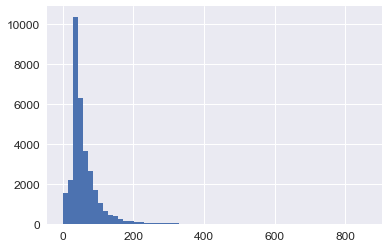

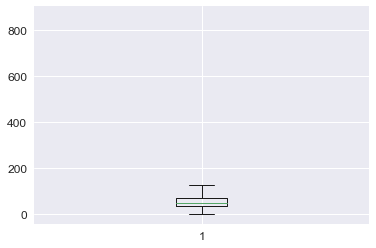

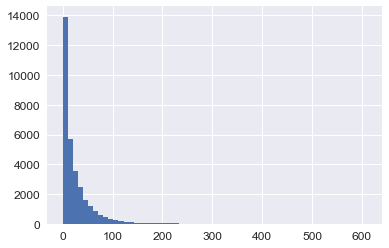

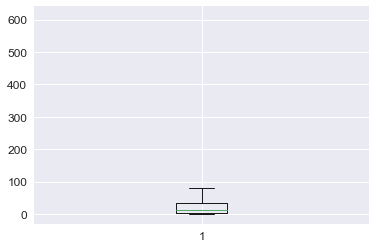

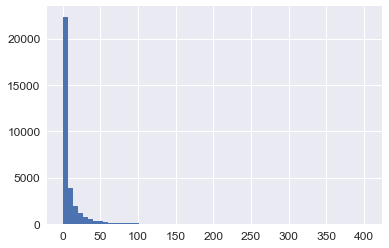

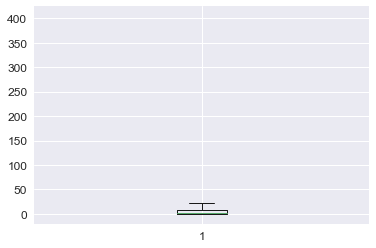

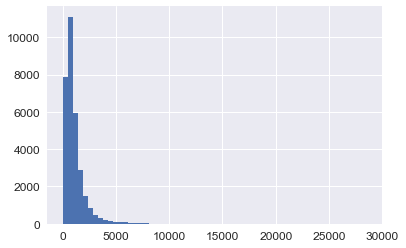

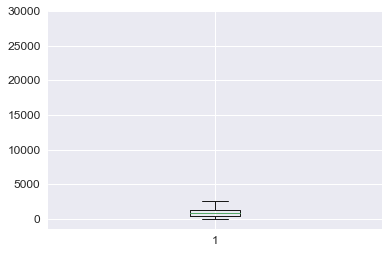

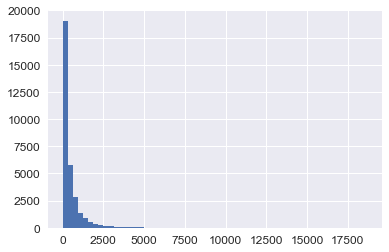

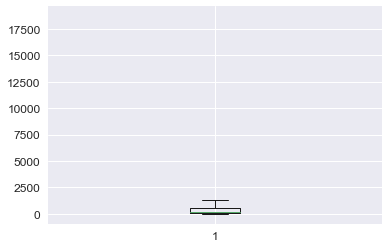

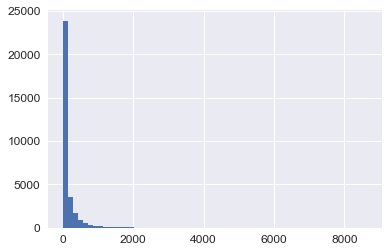

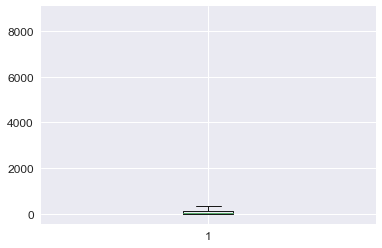

In [106]:
plt.hist(dat['revenue'], bins=60)
plt.show()
plt.boxplot(dat['revenue'])
plt.show()
plt.hist(dat['outcalls'], bins=60)
plt.show()
plt.boxplot(dat['outcalls'])
plt.show()
plt.hist(dat['incalls'], bins=60)
plt.show()
plt.boxplot(dat['incalls'])
plt.show()
plt.hist(dat['totalrev'], bins=60)
plt.show()
plt.boxplot(dat['totalrev'])
plt.show()
plt.hist(dat['totalout'], bins=60)
plt.show()
plt.boxplot(dat['totalout'])
plt.show()
plt.hist(dat['totalin'], bins=60)
plt.show()
plt.boxplot(dat['totalin'])
plt.show()

Based on the histograms and boxplots, I excluded some extraordinarily high value of several variables, and finally, I got 31306 observations and 15 columns.

In [107]:
da = dat[(dat['revenue'] < 350) & (dat['outcalls'] < 200) & (dat['incalls'] < 80) & (dat['totalrev'] < 8000) & (dat['totalout'] < 5500) & (dat['totalin'] < 2000)]
print(da.info())
print(da.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31306 entries, 0 to 31881
Data columns (total 15 columns):
revenue     31306 non-null float64
outcalls    31306 non-null float64
incalls     31306 non-null float64
months      31306 non-null int64
eqpdays     31306 non-null int64
webcap      31306 non-null category
marryyes    31306 non-null category
travel      31306 non-null category
pcown       31306 non-null category
creditcd    31306 non-null category
retcalls    31306 non-null int64
churndep    31306 non-null category
totalrev    31306 non-null float64
totalout    31306 non-null float64
totalin     31306 non-null float64
dtypes: category(6), float64(6), int64(3)
memory usage: 2.6 MB
None
            revenue      outcalls       incalls        months       eqpdays  \
count  31306.000000  31306.000000  31306.000000  31306.000000  31306.000000   
mean      56.462584     22.664199      6.743108     18.679295    394.722705   
std       37.197375     27.902167     11.315830      9.448924

## Step 3: Build model

Set 'churndep' as target variable (y), and other variables as predictor variables (x).

In [108]:
y=da.pop('churndep')
print(y.head())
x=da
print(x.head())

0    1
1    1
2    1
3    1
4    1
Name: churndep, dtype: category
Categories (2, int64): [0, 1]
   revenue  outcalls  incalls  months  eqpdays webcap marryyes travel pcown  \
0    83.53     20.00      1.0      31      745      1        0      0     0   
1    29.99      0.00      0.0      52     1441      0        0      0     1   
2    37.75      2.67      0.0      25      572      0        0      0     1   
3     5.25      0.00      0.0      45     1354      0        0      0     0   
4    42.71      8.67      0.0      27      224      1        0      0     0   

  creditcd  retcalls  totalrev  totalout  totalin  
0        0         4   2589.43    620.00     31.0  
1        1         3   1559.48      0.00      0.0  
2        1         3    943.75     66.75      0.0  
3        0         2    236.25      0.00      0.0  
4        0         3   1153.17    234.09      0.0  


I split the whole dataset into 3 datasets, which were training data set, validation data set and test data set, the proportion was 60%, 20%, 20%.

In [109]:
from sklearn.model_selection import train_test_split
x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.25, random_state=42)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(18783, 14)
(6261, 14)
(6262, 14)


I used several different criterions to build the decision tree model, then I found 2 relatively optimal models.
The following is the first model using 'entropy', and set 'max_leaf_nodes', and 'min_samples_split'.
The confusion matrix and accuracy rate of trainning data, and the tree itself are showed below.

In [110]:
#Code borrowed from class note
tree_clf2 = DecisionTreeClassifier(max_leaf_nodes=30, min_samples_split=600, criterion='entropy')
mod2=tree_clf2.fit(x_train, y_train)
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import confusion_matrix

export_graphviz(
        tree_clf2,
        out_file=image_path("tree2.dot"),
        feature_names=x_train.columns,
        class_names=['No', 'Yes'],
        rounded=True,
        filled=True
    )

y_pred = mod2.predict(x_train)
cnf_matrix = confusion_matrix(y_train, y_pred)
np.set_printoptions(precision=2)
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cm)
accu = (cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(sum(cnf_matrix))
print("Predictive accuracy rate: " + str(accu.round(4)))

[[5752 3696]
 [3782 5553]]
[[0.61 0.39]
 [0.41 0.59]]
Predictive accuracy rate: 0.6019


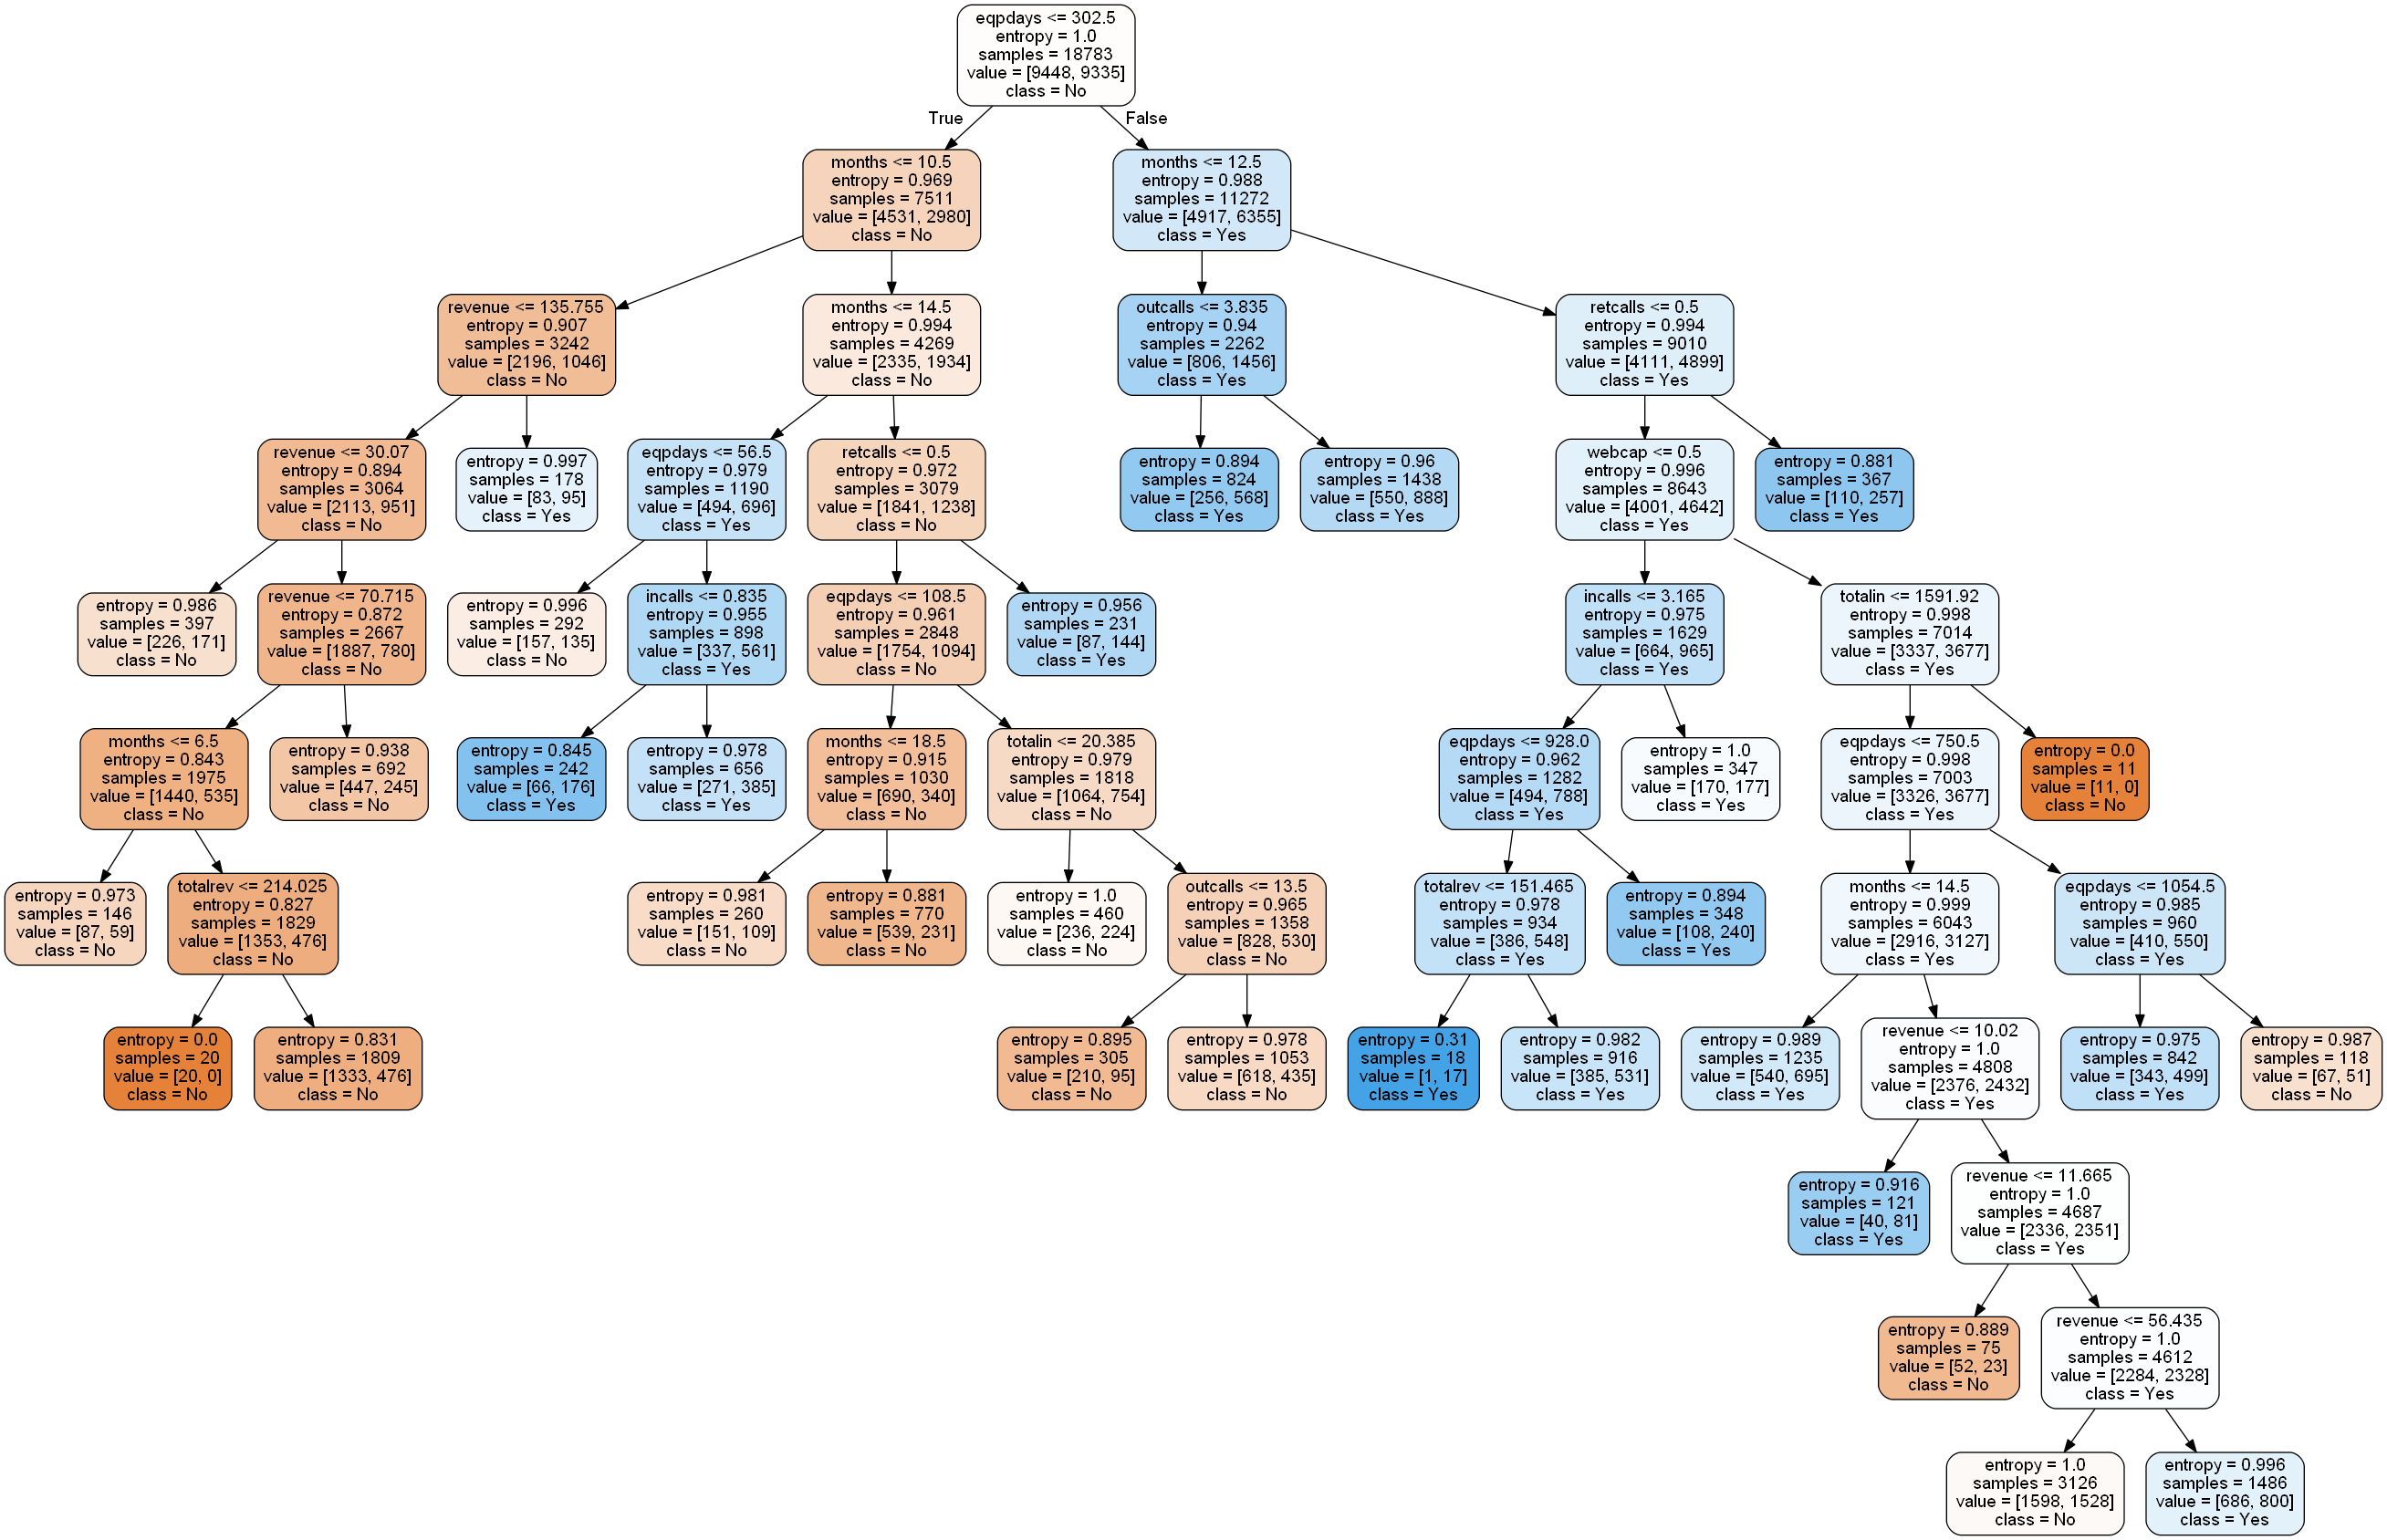

In [111]:
#Code borrowed from class note
path_png = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, "tree2.png")
Image(path_png)

The following is the second model using 'entropy', and set 'min_impurity_decrease'.
The confusion matrix and accuracy rate of trainning data, and the tree itself are showed below.

In [112]:
#Code borrowed from class note
tree_clf3 = DecisionTreeClassifier(min_impurity_decrease=0.001, criterion='entropy')
mod3=tree_clf3.fit(x_train, y_train)

export_graphviz(
        tree_clf3,
        out_file=image_path("tree3.dot"),
        feature_names=x_train.columns,
        class_names=['No', 'Yes'],
        rounded=True,
        filled=True
    )

y_pred = mod3.predict(x_train)
cnf_matrix = confusion_matrix(y_train, y_pred)
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cm)
accu = (cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(sum(cnf_matrix))
print("Predictive accuracy rate: " + str(accu.round(4)))

[[3867 5581]
 [2045 7290]]
[[0.41 0.59]
 [0.22 0.78]]
Predictive accuracy rate: 0.594


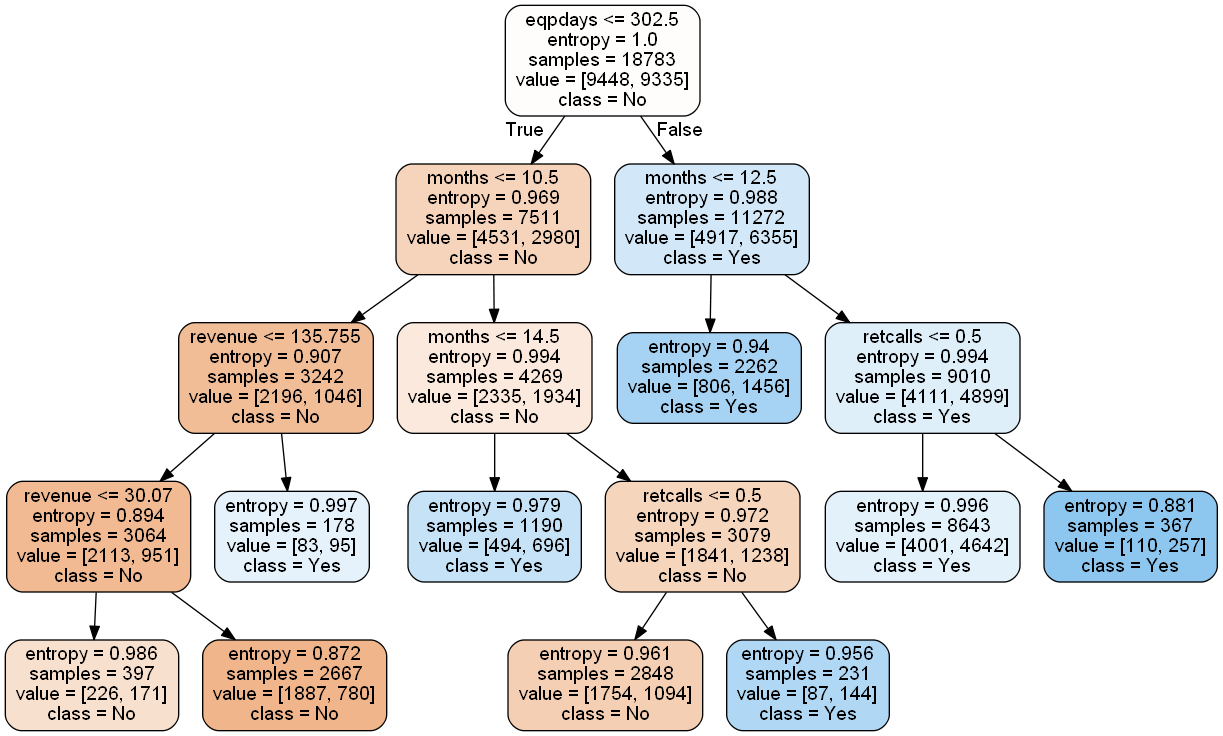

In [113]:
#Code borrowed from class note
path_png = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, "tree3.png")
Image(path_png)

## Step 4: Validate and compare model

Then I used validation dataset to compare the outcome of the two models. I used predictive accuracy rate, classification error rate, precision rate, recall rate and f-measure to validate the accuracy of the model.

From the outcome, I found that the accuracy rate of the two models are very close, the first one is 59.05% and the second one is 60.21%. 
However, in terms of the confusion matrix and other indicators, I found that the first model is a more 'balanced' model, since the precision rate of "No" and "Yes" classes are similar. 
While for the second model, the prediction accuracy of class "Yes" and TP is higher than class "No" and TN. Which means if using the second model, for class "Yes" we will have higher chance that the prediction is accurate.
Since the purpose of this prediction is to reflect customer's decision of terminating the contract or not. Knowing that a customer will terminate the contract is more valuable for the company. Thus, I chose the second model as the final model.

Confusion matrix, without normalization
[[1870 1284]
 [1280 1827]]
Normalized confusion matrix
[[0.59 0.41]
 [0.41 0.59]]


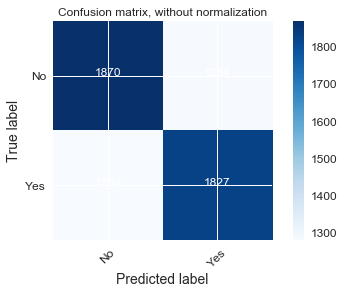

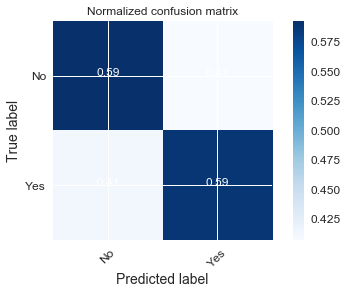

Predictive accuracy rate: 0.5905
Classification error rate: 0.4095
Precision rate of 'No' class: 0.5937
Precision rate of 'Yes' class: 0.5873
Recall rate of 'No' class: 0.5929
Recall rate of 'Yes' class: 0.588
F-measure of 'No' class: 0.5933
F-measure of 'Yes' class: 0.5876


In [114]:
y_pred = mod2.predict(x_val)

#Code borrowed from class note
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(y_val, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accu = (cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(sum(cnf_matrix))
print("Predictive accuracy rate: " + str(accu.round(4)))

err = (cnf_matrix[1,0] + cnf_matrix[0,1]) / sum(sum(cnf_matrix))
print("Classification error rate: " + str(err.round(4)))

preno = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[1,0])
print("Precision rate of 'No' class: " + str(preno.round(4)))

preyes = cnf_matrix[1,1] / (cnf_matrix[0,1] + cnf_matrix[1,1])
print("Precision rate of 'Yes' class: " + str(preyes.round(4)))

recno = cnf_matrix[0,0] / (cnf_matrix[0,1] + cnf_matrix[0,0])
print("Recall rate of 'No' class: " + str(recno.round(4)))

recyes = cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0])
print("Recall rate of 'Yes' class: " + str(recyes.round(4)))

fmno = 2*(preno*recno)/(preno+recno)
print("F-measure of 'No' class: " + str(fmno.round(4)))
fmyes = 2*(preyes*recyes)/(preyes+recyes)
print("F-measure of 'Yes' class: " + str(fmyes.round(4)))

Confusion matrix, without normalization
[[1309 1845]
 [ 646 2461]]
Normalized confusion matrix
[[0.42 0.58]
 [0.21 0.79]]


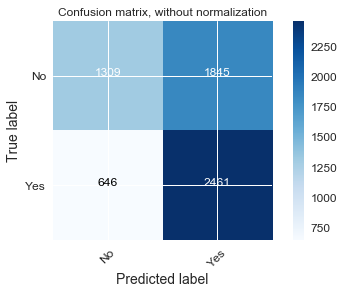

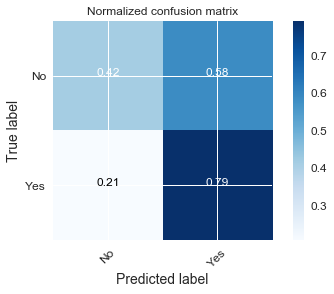

Predictive accuracy rate: 0.6021
Classification error rate: 0.3979
Precision rate of 'No' class: 0.6696
Precision rate of 'Yes' class: 0.5715
Recall rate of 'No' class: 0.415
Recall rate of 'Yes' class: 0.7921
F-measure of 'No' class: 0.5124
F-measure of 'Yes' class: 0.664


In [115]:
y_pred = mod3.predict(x_val)

#Code borrowed from class note
cnf_matrix = confusion_matrix(y_val, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accu = (cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(sum(cnf_matrix))
print("Predictive accuracy rate: " + str(accu.round(4)))

err = (cnf_matrix[1,0] + cnf_matrix[0,1]) / sum(sum(cnf_matrix))
print("Classification error rate: " + str(err.round(4)))

preno = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[1,0])
print("Precision rate of 'No' class: " + str(preno.round(4)))

preyes = cnf_matrix[1,1] / (cnf_matrix[0,1] + cnf_matrix[1,1])
print("Precision rate of 'Yes' class: " + str(preyes.round(4)))

recno = cnf_matrix[0,0] / (cnf_matrix[0,1] + cnf_matrix[0,0])
print("Recall rate of 'No' class: " + str(recno.round(4)))

recyes = cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0])
print("Recall rate of 'Yes' class: " + str(recyes.round(4)))

fmno = 2*(preno*recno)/(preno+recno)
print("F-measure of 'No' class: " + str(fmno.round(4)))
fmyes = 2*(preyes*recyes)/(preyes+recyes)
print("F-measure of 'Yes' class: " + str(fmyes.round(4)))

## Step 5: Test model

Finally, I used test dataset to test the model I chose. 
The Predictive accuracy rate is 0.6021, the classification error rate is 0.3979, the precision rate of 'No' class is 0.6696, the precision rate of 'Yes' class is 0.5715, the recall rate of 'No' class is 0.415, the recall rate of 'Yes' class is 0.7921, the f-measure of 'No' class is 0.5124, and the f-measure of 'Yes' class is 0.664.

Confusion matrix, without normalization
[[1267 1819]
 [ 727 2449]]
Normalized confusion matrix
[[0.41 0.59]
 [0.23 0.77]]


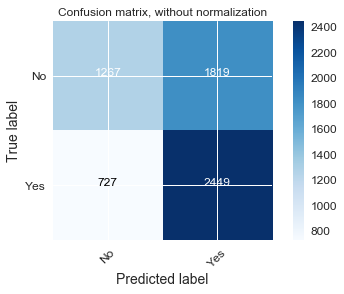

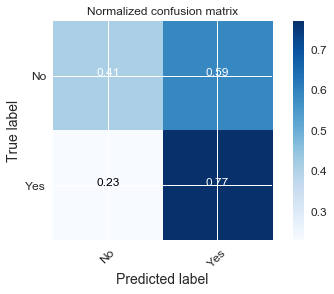

Predictive accuracy rate: 0.6021
Classification error rate: 0.3979
Precision rate of 'No' class: 0.6696
Precision rate of 'Yes' class: 0.5715
Recall rate of 'No' class: 0.415
Recall rate of 'Yes' class: 0.7921
F-measure of 'No' class: 0.5124
F-measure of 'Yes' class: 0.664


In [116]:
y_pred = mod3.predict(x_test)

#Code borrowed from class note    
cnf_matrix2 = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['No','Yes'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['No','Yes'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accu2 = (cnf_matrix2[0,0] + cnf_matrix2[1,1]) / sum(sum(cnf_matrix2))
print("Predictive accuracy rate: " + str(accu.round(4)))

err2 = (cnf_matrix2[1,0] + cnf_matrix2[0,1]) / sum(sum(cnf_matrix2))
print("Classification error rate: " + str(err.round(4)))

preno2 = cnf_matrix2[0,0] / (cnf_matrix2[0,0] + cnf_matrix2[1,0])
print("Precision rate of 'No' class: " + str(preno.round(4)))

preyes2 = cnf_matrix2[1,1] / (cnf_matrix2[0,1] + cnf_matrix2[1,1])
print("Precision rate of 'Yes' class: " + str(preyes.round(4)))

recno2 = cnf_matrix2[0,0] / (cnf_matrix2[0,1] + cnf_matrix2[0,0])
print("Recall rate of 'No' class: " + str(recno.round(4)))

recyes2 = cnf_matrix2[1,1] / (cnf_matrix2[1,1] + cnf_matrix2[1,0])
print("Recall rate of 'Yes' class: " + str(recyes.round(4)))

fmno2 = 2*(preno2*recno2)/(preno2+recno2)
print("F-measure of 'No' class: " + str(fmno.round(4)))
fmyes2 = 2*(preyes2*recyes2)/(preyes2+recyes2)
print("F-measure of 'Yes' class: " + str(fmyes.round(4)))